In [1]:
import numpy as np
import pandas as pd

# PANEL DATA

Il file 'Paneldata.xlsx' contiene dati di bilancio relativi a 25 aziende incluse nell'indice STOXX Europe 50 riguardanti il periodo 2010-2019. In particolare sono state osservate le seguenti variabili:
- ##### ROE - $ Y $
- ##### EBIT - $ X_1 $
- ##### EBITDA - $ X_2 $
- ##### Market Capitalization - $ X_3 $

Il nostro obiettivo consiste nello stimare una regressione per dati panel e stabilire se il modello ad effetti random produce risultati di stima migliori di quello ad effetti fissi. Scegliamo il ROE come variabile dipendente e le altre come variabili esplicative. 
Importiamo i dati e li prepariamo all'analisi:

In [2]:
# import data
data_t = pd.read_excel('~/PycharmProjects/Econometrics-Course/jupyter_lessons/Paneldata.xlsx')
data = data_t.loc[:, ['i', 'FY', 'ROE', 'EBIT', 'EBITDA', 'MktCap']]  # take data of interest

# data cleaning
data.loc[:, 'ROE'] = data.loc[:, 'ROE'] * 100 # ROE from decimal base to percentage base; Pythonic_way: data.loc[:, 'ROE'] *= 100
data.loc[:, "EBIT":] = data.loc[:, "EBIT":] / 10**9  # express them in Billions; Pythonic_way: data.loc[:, "EBIT":] /= 10e9

data

,i,FY,ROE,EBIT,EBITDA,MktCap
0,1,2010,13.520,1.120,0.871,68.685753
1,1,2011,13.500,1.205,0.952,75.956291
2,1,2012,14.880,1.451,1.187,105.630213
3,1,2013,15.550,1.520,1.234,124.222073
4,1,2014,8.818,1.290,0.975,150.949609
...,...,...,...,...,...,...
245,25,2015,2.040,13.869,2.172,65.088307
246,25,2016,2.900,13.799,2.713,75.469377
247,25,2017,4.600,14.879,4.470,77.714954
248,25,2018,2.230,13.796,4.001,49.335798


#### VISUALIZATION (not mandatory but really useful in a DataScience world)

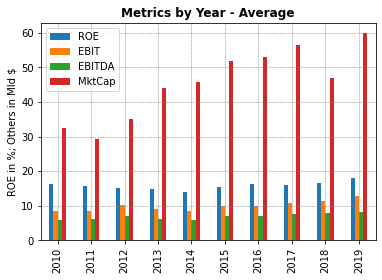

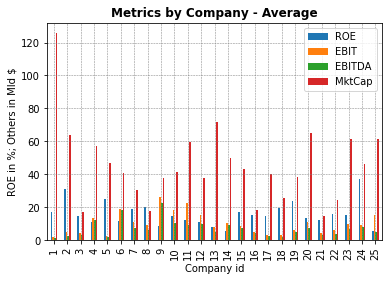

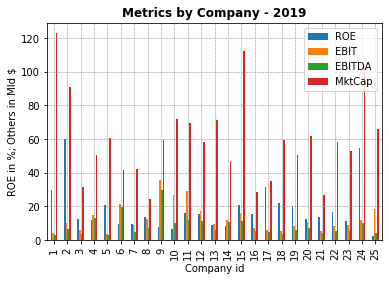

The first 15 biggest company rapresents 74.74% of the Total Market Capitalization. Visualize them:


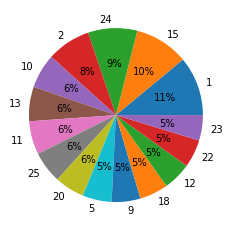

Multi-Index Approach (for advanced Pandas users):


ROE       EBIT     EBITDA      MktCap
FY   i                                           
2010 1   13.520   1.120000   0.871000   68.685753
     2    5.708   2.455000   1.016000   40.418685
     3   17.027   3.394700   2.262000    7.018085
     4   11.900  12.634000  11.502000   65.447564
     5   44.927   1.446936   1.180926   28.885297
...         ...        ...        ...         ...
2019 21  13.849   5.290000   4.115000   26.628500
     22  16.460   8.471000   5.431000   58.080611
     23  11.300   8.810000   5.653000   52.817875
     24  54.429  11.911000   9.947000  102.188428
     25   2.660  18.630000   4.456000   66.026858

[250 rows x 4 columns]

In [3]:
import matplotlib.pyplot as plt

# Metrics by Financial Years
metrics = data.drop("i", axis=1)
metrics.groupby(metrics["FY"]).mean().plot.bar()
plt.title('Metrics by Year - Average', fontweight='bold')
plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.ylabel('ROE in %; Others in Mld $')
plt.xlabel('')
plt.show()

# Metrics by Company id
metrics = data.drop("FY", axis=1)
metrics.groupby(metrics["i"]).mean().plot.bar()
plt.title('Metrics by Company - Average', fontweight='bold')
plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.ylabel('ROE in %; Others in Mld $')
plt.xlabel('Company id')
plt.show()

# Today Metrics (last FY)
metrics.groupby(metrics["i"]).last().plot.bar()
plt.title('Metrics by Company - 2019', fontweight='bold')
plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.ylabel('ROE in %; Others in Mld $')
plt.xlabel('Company id')
plt.show()

# Printing stuff (for fun)
BOLD = '\033[1m'
DARKCYAN = '\033[36m'
UNDERLINE = '\033[4m'
END = '\033[0m'

# Market-Cap view
mktcap = metrics.groupby(metrics["i"]).last()["MktCap"]
mktcap_perc = (mktcap / mktcap.sum()).sort_values(ascending=False)
top = 15
print(f'{BOLD}{DARKCYAN}The first {top} biggest company rapresents {round(mktcap_perc[:top].sum(), 4) * 100}% of the Total Market Capitalization. Visualize them:')
plt.pie(labels=mktcap_perc[:top].index, x=mktcap_perc[:top], autopct='%1.0f%%', normalize=True)
plt.show()

print(BOLD + DARKCYAN + "Multi-Index Approach " + END + UNDERLINE + "(for advanced Pandas users):")
# Double-groupby using Multi-Index approach (for advanced Pandas users)
data.groupby([data["FY"], data["i"]]).mean()

### Back to the FIXED EFFECTS Analysis

Let us go back to the equation for the estimation of the fixed effects model:
$\\ \frac{1}{T} \displaystyle\sum_{t=1}^{T} y_{jt} = \alpha_j + \beta \frac{1}{T} \displaystyle\sum_{t=1}^{T} x_{jt} + \frac{1}{T} \displaystyle\sum_{t=1}^{T} u_{jt}$

or in equivalent way:
$ \\ \bar y_{j} = \alpha_j + \beta \bar x_j + \bar u_j $

By centering the variables (subtracting the mean) we obtain a model "purified" from the fixed effects $ \alpha_j $:
$ \\ y_{jt} - \bar y_j = \beta (x_{jt} - \bar x_j) + u_{jt} - \bar u_j $

Now we can obtain the estimation for $ \hat\beta $ with the OLS method and then we will recover the fixed effects estimationsì using:
$ \\\hat\alpha_j = \bar y_j - \hat\beta \bar x_j $


In [4]:
N = data.iloc[-1, 0]  # N is equal to the last value of i (i is the id); Pythonic_way: N = data["i"].unique()[-1]

data_centered = data.copy(deep=True)  # make a deep copy is mandatory to avoid that the pointer points to the same memory addres. We're basically saving the same DataFrame in a differente memory address
for id in range(1, N+1):
    raw = data.loc[data["i"] == id, "ROE":]
    data_centered.loc[data["i"] == id, "ROE":] = raw - raw.mean()

# data_centered.head(10)

In [6]:
# define Y and X. For X we no need the column of ones
Y = data_centered.loc[:, "ROE"]
X = data_centered.loc[:, "EBIT":]

# compute Betas coefficients
betas = np.linalg.inv(X.T @ X) @ X.T @ Y
betas.index = X.columns
print(BOLD + DARKCYAN + 'Beta Coefficients:' + END)
print(betas)

Beta Coefficients:
EBIT     -0.630365
EBITDA    1.298783
MktCap    0.028986
dtype: float64


## Calc Fixed Effects

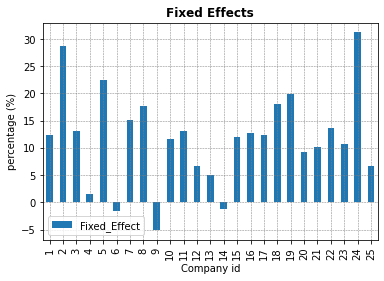

In [7]:
# Pythonic_way
avg = data.loc[:, ["i", "ROE", "EBIT", "EBITDA", "MktCap"]]
avg = avg.groupby(avg["i"]).mean()
fixed_effects = avg["ROE"] - avg.loc[:, "EBIT":] @ betas

# just for visualization (try to print fixed_effects without put it in a DataFrame)
fixed_effects = pd.DataFrame(data=fixed_effects, index=data["i"].unique(), columns=["Fixed_Effect"])
fixed_effects.plot.bar()
plt.title('Fixed Effects', fontweight='bold')
plt.grid(linestyle='--', linewidth=0.5, color='gray')
plt.ylabel('percentage (%)')
plt.xlabel('Company id')
plt.show()

### RANDOM EFFECTS

In [8]:
from linearmodels.panel import RandomEffects
import statsmodels.api as sm
from linearmodels.datasets import wage_panel
from itertools import product

multi = list(product(range(1, N+1), data["FY"].unique()))
star = data.drop(["i", "FY"], axis=1)
star.index = pd.MultiIndex.from_tuples(multi, names=["firm_id", "FY"])

model = RandomEffects(star["ROE"], star.loc[:, "EBIT":])
model.fit()

C:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Dep. Variable:,ROE,R-squared:,0.1366
Estimator:,RandomEffects,R-squared (Between):,0.4744
No. Observations:,250,R-squared (Within):,0.0439
Date:,"Sat, Feb 19 2022",R-squared (Overall):,0.4360
Time:,19:06:39,Log-likelihood,-790.87
Cov. Estimator:,Unadjusted,,
,,F-statistic:,13.023
Entities:,25,P-value,0.0000
Avg Obs:,10.0000,Distribution:,"F(3,247)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,13.023
